In [30]:
from keras.layers import (Conv2D, Conv2DTranspose, UpSampling2D, Activation, Dense, Dropout, Flatten, InputLayer)
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [31]:
X=[]
count=0
for filename in os.listdir('../color_photo_data/images/Train'):
    X.append(img_to_array(load_img('../color_photo_data/images/Train/' + filename)))
    if count==501: break
    count += 1
X = np.array(X, dtype = float)
X =X/255.0

In [32]:
X=X[:500]

In [33]:
split_ratio = 0.9
split = int(X.shape[0]*split_ratio)
val_ratio = 0.9
val_split = int(val_ratio*split)
X_train = X[:val_split]
X_val = X[val_split:split]
X_test = X[split:]


In [50]:
model = Sequential()
model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(Conv2D(64, (3, 3), activation='selu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='selu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='selu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='selu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='selu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='selu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='selu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='selu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='selu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='selu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
opt = Adam(lr=1e-2)
model.compile(optimizer=opt, loss='mse')

In [35]:
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True
)

def image_a_b_gen(batch_size, X_train):
    for batch in datagen.flow(X_train, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)


In [36]:
import keras
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

batch_size=100
num_batches = int(X_train.shape[0]/batch_size)+1
validation_steps = int(X_val.shape[0]/batch_size)+1

In [51]:
model.fit_generator(image_a_b_gen(batch_size, X_train), num_batches, epochs=10, 
                    validation_data=image_a_b_gen(batch_size, X_val),
                    validation_steps=validation_steps,callbacks=[callback])

Epoch 1/10
5/5 [==============================] - 114s 23s/step - loss: 0.9478 - val_loss: 1.0419
Epoch 2/10
5/5 [==============================] - 93s 19s/step - loss: 1.0225 - val_loss: 1.0397
Epoch 3/10
5/5 [==============================] - 84s 17s/step - loss: 1.0191 - val_loss: 1.0395
Epoch 4/10
5/5 [==============================] - 85s 17s/step - loss: 1.0260 - val_loss: 1.0400
Epoch 5/10
4/5 [=======================>......] - ETA: 20s - loss: 1.0181

KeyboardInterrupt: 

In [38]:
model_json = model.to_json()
with open('model_beta.json','w') as json_file:
    json_file.write(model_json)
model.save_weights('model.h5')

In [39]:
Xtest = rgb2lab(X_test)[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(X_test)[:,:,:,1:]
Ytest = Ytest / 128

In [40]:
recolored = model.predict(Xtest)
recolored = recolored * 128

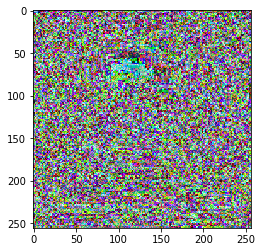

In [46]:
img_idx=2
img_recolor = np.zeros((256, 256, 3))
img_recolor[:,:,0] = Xtest[img_idx,:,:,0]
img_recolor[:,:,1:] = recolored[img_idx]
plt.imshow(img_recolor)

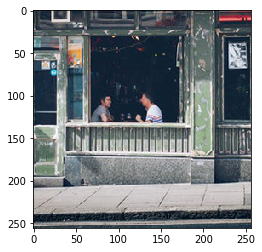

In [47]:
plt.imshow(X_test[img_idx])